In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train[y_train == 7]
# y_train = y_train[y_train == 7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 2000

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

x_train = x_train / 255.
x_test = x_test / 255.

x_train_inv = np.abs(x_train - 1)
x_test_inv = np.abs(x_test - 1)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_train_inv = np.reshape(x_train_inv, (len(x_train_inv), 28, 28, 1))

x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_test_inv = np.reshape(x_test_inv, (len(x_test_inv), 28, 28, 1))

(60000, 28, 28) (60000,)


In [4]:
x_t = np.stack((x_train, x_train_inv), axis=3)
print(x_t.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(x_t).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for i, element in enumerate(train_dataset.as_numpy_iterator()):
	print(element.shape)
	if i == 4: break

(60000, 28, 28, 2, 1)
(2000, 28, 28, 2, 1)
(2000, 28, 28, 2, 1)
(2000, 28, 28, 2, 1)
(2000, 28, 28, 2, 1)
(2000, 28, 28, 2, 1)


In [23]:
for i, element in enumerate(train_dataset):
	print(element.numpy().shape)
	if i == 4: break

(1024, 28, 28, 2, 1)
(1024, 28, 28, 2, 1)
(1024, 28, 28, 2, 1)
(1024, 28, 28, 2, 1)
(1024, 28, 28, 2, 1)


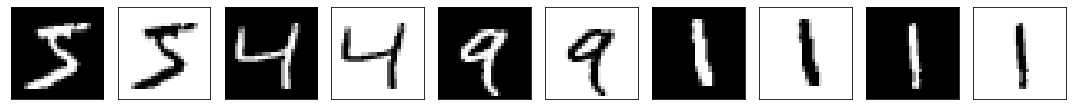

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, _ in enumerate(axs.flat):
	if i%2 == 0:
		axs[i].imshow(x_t[i, :, :, 0], cmap='gray')
		axs[i+1].imshow(x_t[i, :, :, 1], cmap='gray')
plt.tight_layout()
plt.show()

In [5]:
# формирование сетей
hidden_dim = 784

# генератор
generator = tf.keras.Sequential([
	Flatten(),
	Dense(7 * 7 * 256, activation='relu'),
	# Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
	BatchNormalization(),
	Reshape((7, 7, 256)),
	Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
	BatchNormalization(),
	Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
	BatchNormalization(),
	Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

In [6]:
# дискриминатор
discriminator = tf.keras.Sequential([
	Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
	LeakyReLU(),
	Dropout(0.3),
	Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
	LeakyReLU(),
	Dropout(0.3),
	Flatten(),
	Dense(1, activation = 'sigmoid')
])

In [7]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
	loss = cross_entropy(tf.ones_like(fake_output), fake_output)
	return loss


def discriminator_loss(real_output, fake_output):
	real_loss = cross_entropy(tf.ones_like(real_output), real_output)
	fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
	total_loss = real_loss + fake_loss
	return total_loss


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

In [8]:
# обучение
@tf.function
def train_step(orig, inv):
	# noise = tf.random.normal([BATCH_SIZE, hidden_dim])

	with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
		generated_images = generator(orig, training=True)

		real_output = discriminator(inv, training=True)
		fake_output = discriminator(generated_images, training=True)

		gen_loss = generator_loss(fake_output)
		disc_loss = discriminator_loss(real_output, fake_output)

	gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
	gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

	print(len(gradients_of_generator))

	generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
	discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

	return gen_loss, disc_loss

In [9]:
def train(dataset, epochs):
	history = []
	MAX_PRINT_LABEL = 5
	th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

	for epoch in range(1, epochs + 1):
		print(f'{epoch}/{EPOCHS}: ', end='')

		start = time.time()
		n = 0

		gen_loss_epoch = 0
		disc_loss_epoch = 0
		for image_batch in dataset:
			orig = image_batch.numpy()[:, :, :, 0]
			inv = image_batch.numpy()[:, :, :, 1]
			gen_loss, disc_loss = train_step(orig, inv)
			disc_loss_epoch += K.mean(disc_loss)
			gen_loss_epoch += K.mean(gen_loss)
			if (n % th == 0): print('=', end='')
			n += 1

		history += [(gen_loss_epoch / n, disc_loss_epoch / n)]
		print(': ' + str(history[-1][0]))
		print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

	return history

In [ ]:
EPOCHS = 100
history = train(train_dataset, EPOCHS)

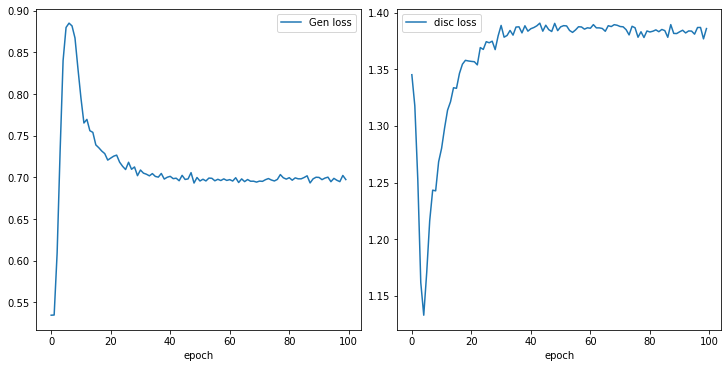

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))
axs[0].plot([i for i in range(EPOCHS)], [history[i][0] for i in range(EPOCHS)], label='Gen loss')
axs[0].set_xlabel('epoch')
axs[0].legend()
axs[1].plot([i for i in range(EPOCHS)], [history[i][1] for i in range(EPOCHS)], label='disc loss')
axs[1].set_xlabel('epoch')
axs[1].legend()
plt.show()

In [12]:
generator.save('generator100fromImgs2')

INFO:tensorflow:Assets written to: generator100fromImgs2\assets


In [24]:
reconstructed_model = tf.keras.models.load_model('generator100fromImgs2')

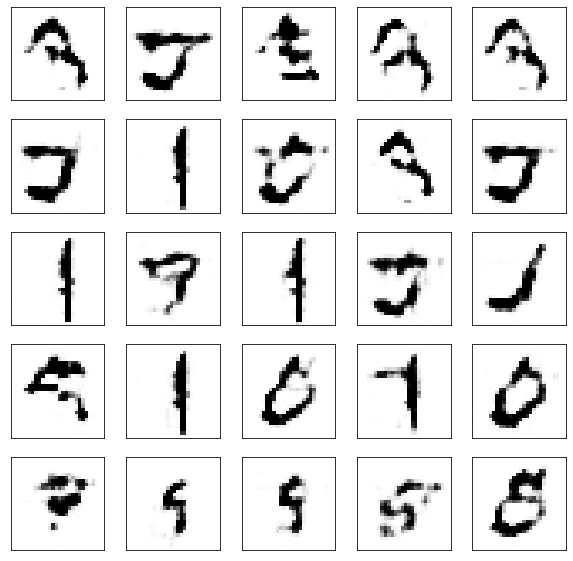

In [25]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total*2, total*2))

num = 1
for i in range(-n, n + 1):
	for j in range(-n, n + 1):
		ax = plt.subplot(total, total, num)
		num += 1
		#img = generator.predict(np.random.randn(1, hidden_dim))
		index = np.random.choice(x_test.shape[0], 1, replace=False)
		img = reconstructed_model.predict(x_test[index])
		plt.imshow(img[0, :, :, 0], cmap='gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)

plt.show()

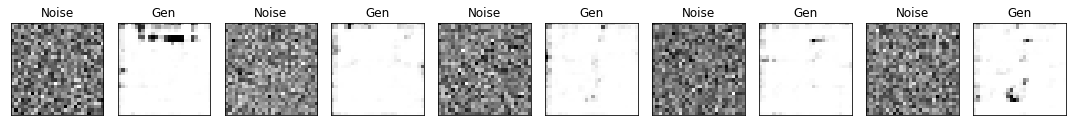

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, _ in enumerate(axs.flat):
	if i%2 == 0:
		test = np.random.randn(1, 28, 28, 1)
		img = reconstructed_model.predict(test)
		axs[i].imshow(np.squeeze(test), cmap='gray')
		axs[i].set_title('Noise')
		axs[i+1].imshow(np.squeeze(img), cmap='gray')
		axs[i+1].set_title('Gen')
plt.tight_layout()
plt.show()

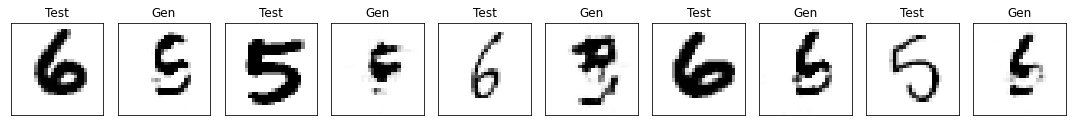

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, _ in enumerate(axs.flat):
	if i%2 == 0:
		index = np.random.choice(x_test.shape[0], 1, replace=False)
		img = reconstructed_model.predict(x_test[index])
		axs[i].imshow(np.squeeze(x_test_inv[index]), cmap='gray')
		axs[i].set_title('Test')
		axs[i+1].imshow(np.squeeze(img), cmap='gray')
		axs[i+1].set_title('Gen')
plt.tight_layout()
plt.show()

In [21]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 12544)             9847040   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        2

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [29]:
noise_model = tf.keras.models.load_model('generator100')

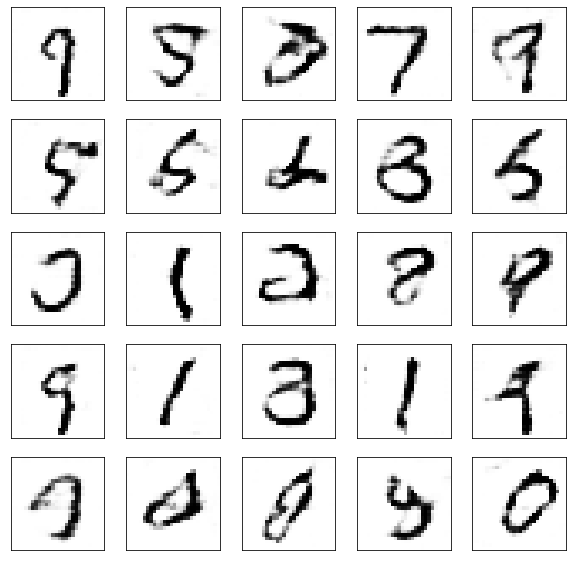

In [33]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total*2, total*2))

num = 1
for i in range(-n, n + 1):
	for j in range(-n, n + 1):
		ax = plt.subplot(total, total, num)
		num += 1
		noise = np.random.randn(1, 100)
		img = noise_model.predict(noise)
		plt.imshow(np.squeeze(img), cmap='gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)

plt.show()

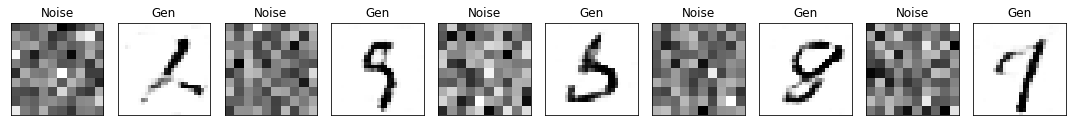

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, _ in enumerate(axs.flat):
	if i%2 == 0:
		test = np.random.randn(1, 100)
		img = noise_model.predict(test)
		axs[i].imshow(test.reshape(10, 10), cmap='gray')
		axs[i].set_title('Noise')
		axs[i+1].imshow(np.squeeze(img), cmap='gray')
		axs[i+1].set_title('Gen')
plt.tight_layout()
plt.show()